In [1]:
##1
## Importing Modules

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm #just to get the progress bar 
warnings.filterwarnings('ignore')

%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D ,Dropout, Flatten, MaxPooling2D, Input


In [2]:
##2 (CHANGER LA DIRECTORY)
## Load Dataset

BASE_DIR=r"C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset"

In [3]:
##3
#labels: race, gender, ethnicity

image_paths=[]
age_labels=[]
gender_labels=[]


for filename in tqdm(os.listdir(BASE_DIR)): #iterates in all the files inside the direcetory
    image_path=os.path.join(BASE_DIR,filename)
    temp=filename.split('_') #on split le nom de l'image selon les _ pour avoir age , date etc..
    age =int(temp[0])#premier element de la liste
    gender =int(temp[1])#second element de la liste
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    
    #la barre en bas montre que we loaded all the images 
    

  0%|          | 0/24103 [00:00<?, ?it/s]

In [5]:
##4
#convert my images into a data frame
df=pd.DataFrame()
df['image'],df['age'],df['gender']=image_paths, age_labels, gender_labels # ce sont les colonnes de mon dataframe
df.sample(10) #cette commande nous permet de voir les premieres lignes, on a creer a proper dataframe


,image,age,gender
17950,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,4,0
14496,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,37,0
6275,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,26,0
2156,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,1,0
3103,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,20,1
9744,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,29,0
11024,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,30,0
1636,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,1,0
5794,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,25,1
20539,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,5,0


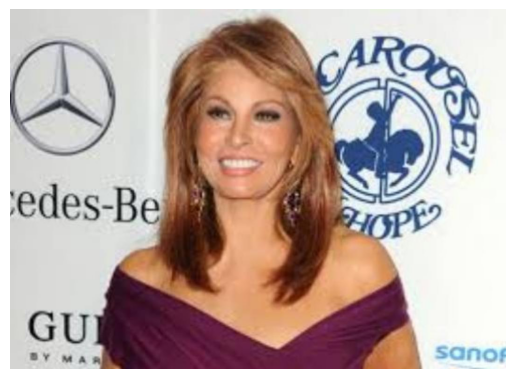

In [10]:
##5
import random
# Exploratory Data Analysis
from PIL import Image  # PIL est un module utilise pour loader des images 
img= Image.open(df['image'][random.randint(0, len(df) - 1)]) #on ouvre juste une image aléatoire
plt.axis('off')
plt.imshow(img);
#for better image preproceessing et ne pas surcharge la RAM, La RAM EST LIMITE on utilise grayscale et on la reesize

In [11]:
##10
## Extracting features
from tensorflow.keras.preprocessing.image import load_img

def extract_features(images):
    features=[]
    for image in tqdm (images):
         #on ne peux pas  se permettre de load toutes les images en RGB: 3 dimensions  et prendre toute la memoire
        img = load_img(image)
        #img = load_img(image, color_mode='grayscale')
        img=img.resize((128,128),Image.ANTIALIAS)
        img=np.array(img)
        features.append(img)
        
    #we convert the features to a numpy array
    features=np.array(features) # cette etape est obligatoire car les neurals network gere que les array 
    features=features.reshape(len(features),128,128,3) #ca prend en arguments number fo features, width, height et la dimension
    # dans notre cas grayscale image ducoup dimension=1
    #dans le cas ou on sera rester en RGB, on oublie ceci 
    return features 
    
        

In [12]:
##11
X=extract_features(df['image'])

  0%|          | 0/24103 [00:00<?, ?it/s]

In [13]:
##12
X.shape
#on verifie bien que la dernier valeur est 1 cad il est en graycale

(24103, 128, 128, 3)

In [ ]:
##13
#normalize the images 
X=X/255.0 #la valeur dee la pixel est de 0-255 maintenant  elle sera de la range 0 to 1 

In [15]:
##14
y_gender=np.array(df['gender']) #on convertit to numpy
y_age=np.array(df['age']) #on convertir to numpy 

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf


# Définir le callback
checkpoint_callback = ModelCheckpoint(
    filepath='VGG16Sex.keras',
    monitor='val_accuracy',  # Correct output accuracy for monitoring
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

# Charger le modèle VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Ajouter les couches personnalisées
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

# Créer et compiler le modèle
model = Model(inputs=vgg16.input, outputs=[gender_output])
model.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy'},
              metrics={'gender_output': 'accuracy'})

# Entraîner le modèle avec un sous-ensemble des données pour les tests
X_sample = X[:100]  # Prenez un sous-ensemble de 100 exemples pour les tests initiaux
y_gender_sample = y_gender[:100]


# Train the model
history = model.fit(x=X, y=y_gender, epochs=20, batch_size=32, validation_split=0.2, callbacks=[checkpoint_callback])




Epoch 1/10
  2/603 ━━━━━━━━━━━━━━━━━━━━ 55:50 6s/step - accuracy: 0.6484 - loss: 26.6183 

KeyboardInterrupt: 

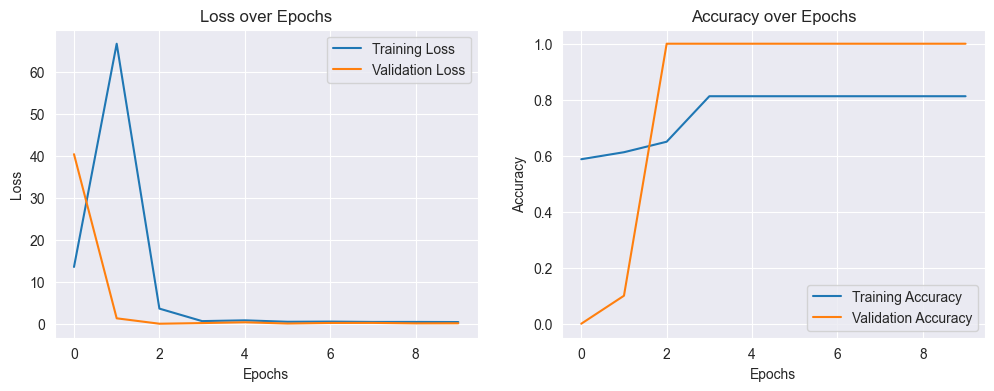

In [26]:
# Plotting the training history for loss and accuracy
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

checkpoint_callback2 = ModelCheckpoint(
    filepath='VGG16Age.keras',
    monitor='val_mae',  # Use the correct output accuracy for monitoring
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Charger le modèle VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Ajouter les couches personnalisées
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
age_output = Dense(1, activation='linear', name='age_output')(x)

# Créer et compiler le modèle
model = Model(inputs=vgg16.input, outputs=[age_output])
model.compile(optimizer='adam',
              loss={'age_output': 'mean_squared_error'},
              metrics={'age_output': 'mae'})

# Entraîner le modèle avec un sous-ensemble des données pour les tests
X_sample = X[:100]  # Prenez un sous-ensemble de 100 exemples pour les tests initiaux
y_age_sample = y_age[:100]


# Train the model
history = model.fit(x=X, y=y_age, epochs=20, batch_size=32, validation_split=0.2, callbacks=[checkpoint_callback2])

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 14536.4971 - mae: 87.2148
Epoch 1: val_mae improved from inf to 302.92218, saving model to VGG16Age.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - loss: 15417.5342 - mae: 91.0508 - val_loss: 99831.2031 - val_mae: 302.9222
Epoch 2/10


KeyboardInterrupt: 

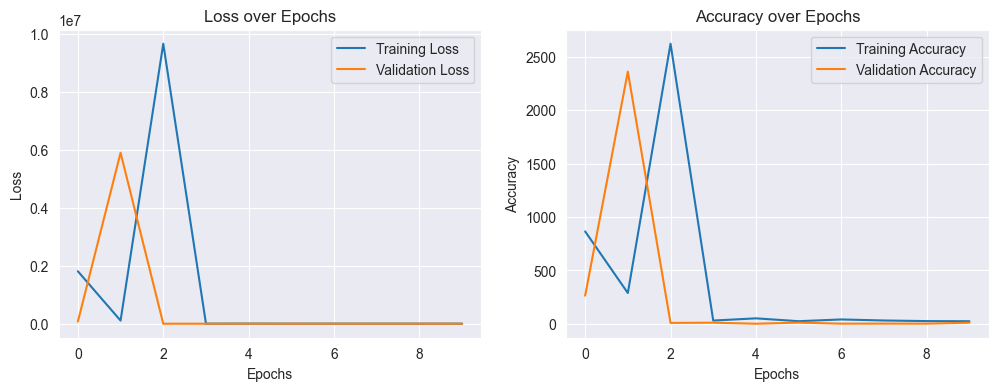

In [24]:
# Plotting the training history for loss and accuracy
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training Accuracy')
plt.plot(history.history['val_mae'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
